In [2]:
from typing import List
import random

import torch
import torch.nn as nn
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%config InlineBackend.figure_format = "svg"

## TTMatrix and autograd

In [2]:
a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])

In [3]:
b = torch.rand(200, 100)

In [4]:
c = b @ a.torch()
cc = tn.tt_multiply(a, b)
torch.allclose(c, cc)

True

By default cores don't require grad.

In [5]:
[core.requires_grad for core in a.cores], [core.is_leaf for core in a.cores]

([False, False], [True, True])

So let's turn them on.

In [6]:
a.cores = [core.requires_grad_() for core in a.cores]
[core.requires_grad for core in a.cores], [core.is_leaf for core in a.cores]

([True, True], [True, True])

_Note: if you try to create TTMatrix from tensor, which requires grad, cores won't be leaf tensors. So they won't keep `.grad` and we will not be able to optimize._

In [7]:
bad_a = tn.TTMatrix(torch.rand(100, 50, requires_grad=True) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
[core.requires_grad for core in bad_a.cores], [core.is_leaf for core in bad_a.cores]

([True, True], [False, False])

### SGD with TTMatrix

In [8]:
a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
a.cores = [core.requires_grad_() for core in a.cores]
b = torch.rand(1, 100)

In [9]:
def compute_loss(weight, target):
    return torch.sum(torch.square(tn.tt_multiply(weight, target)))

def sgd_step(weight, target, lr):
    loss = compute_loss(weight, target)
    loss.backward()
    
    with torch.no_grad():
        for core in weight.cores:
            core -= lr * core.grad
            core.grad.zero_()

    return loss.item()

def train_sgd(weight, target, lr, n_steps):
    losses = []

    for i in range(n_steps):
        loss = sgd_step(a, b, lr)
        losses.append(loss)

    return losses

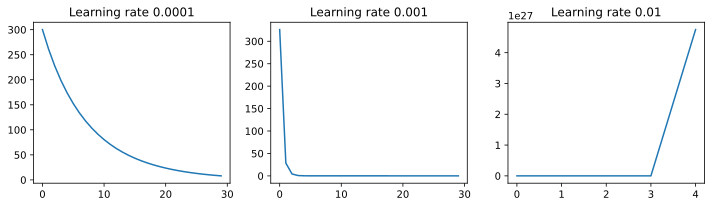

In [10]:
plt.figure(figsize=(10, 3))
for i, lr in enumerate((1e-4, 1e-3, 1e-2)):
    a = tn.TTMatrix(torch.rand(100, 50) / 10, ranks=[4], input_dims=[10, 10], output_dims=[10, 5])
    a.cores = [core.requires_grad_() for core in a.cores]
    b = torch.rand(1, 100)

    losses = train_sgd(a, b, lr, 30)
    
    plt.subplot(1, 3, i + 1)
    plt.plot(losses)
    plt.title(f"Learning rate {lr}")

plt.tight_layout()
plt.show()

For big learning rates optimization is unstable.

## Implement layer

In [ ]:
def tt_multiply(tt_matrix: TTMatrix, tensor: torch.Tensor):
    """
    Multiply TTMatrix by any tensor of more than 1-way.
    For vectors, reshape them to matrix of shape 1 x I
    returns: torch.Tensor of shape b x num_cols(tt_matrix)
    """

    assert len(tensor.shape) > 1

    rows = torch.prod(tt_matrix.input_dims)
    b = tensor.reshape(-1, rows).shape[0]
    tensor = tensor.reshape(b, -1).T
    result = tensor.reshape(tt_matrix.input_dims[0], -1)
    result = torch.einsum('id,lior->ldor', result, tt_matrix.cores[0])

    for d in range(1, tt_matrix.d):
        result = result.reshape(tt_matrix.input_dims[d], -1, tt_matrix.cores[d].shape[0])
        result = torch.einsum('idr,riob->dob', result, tt_matrix.cores[d])

    return result.reshape(b, -1)

In [3]:
class TTLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int], 
                 output_dims: List[int], bias: bool = True, device=None, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = ranks
        self.input_dims = input_dims
        self.output_dims = output_dims

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / np.sqrt(in_features)
        self.weight = tn.TTMatrix(init, ranks, input_dims, output_dims)
        
        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to specify them
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / np.sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = tn.tt_multiply(self.weight, x)
        if self.bias is not None:
            res += self.bias
        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = linear.bias.data.clone() if linear.bias is not None else None


In [4]:
model = TTLinear(100, 50, [4], [10, 10], [10, 5], bias=False)

In [5]:
[p.shape for p in model.parameters()]

[torch.Size([1, 10, 10, 4]), torch.Size([4, 10, 5, 1])]

### Test training

In [6]:
#opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [7]:
dataset = torch.rand(20, 100)
target = torch.rand(20, 50)

In [8]:
def train_one_epoch(dataset, target, model, opt, criterion):
    losses = []

    for step, (x, y) in enumerate(zip(dataset, target)):
        opt.zero_grad()
        predict = model(x.reshape(1, -1)).squeeze()
        loss = criterion(predict, y)
        assert not torch.isnan(loss).any(), f"Nan at step {step}"
        loss.backward()
        opt.step()

        losses.append(loss.item())
    return losses

def train(dataset, target, model, opt, criterion, n_epochs):
    losses = []
    for epoch in range(n_epochs):
        epoch_losses = train_one_epoch(dataset, target, model, opt, criterion)
        losses.extend(epoch_losses)
    return losses

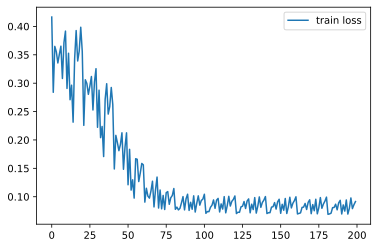

In [9]:
losses = train(dataset, target, model, opt, criterion, n_epochs=10)

plt.plot(losses, label="train loss")
plt.legend()
plt.show()

### Test init from full linear

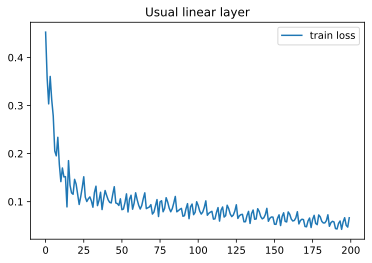

In [10]:
pretrained_model = nn.Linear(100, 50, bias=False)
opt = torch.optim.Adam(pretrained_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = train(dataset, target, pretrained_model, opt, criterion, n_epochs=10)

plt.title("Usual linear layer")
plt.plot(losses, label="train loss")
plt.legend()
plt.show()

In [11]:
model = TTLinear(100, 50, [4], [10, 10], [10, 5], bias=False)
model.set_from_linear(pretrained_model)

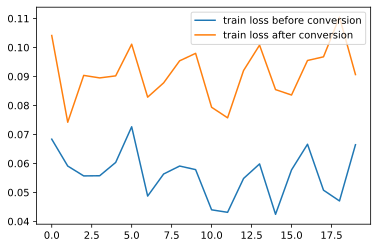

In [12]:
plt.plot(losses[-dataset.shape[0]:], label="train loss before conversion")

losses = train_one_epoch(dataset, target, model, opt, criterion)

plt.plot(losses, label="train loss after conversion")
plt.legend()
plt.show()

## Bigger models

In [13]:
model = nn.Sequential(
    TTLinear(100, 80, [8], [10, 10], [10, 8]),
    nn.ReLU(),
    TTLinear(80, 50, [8], [10, 8], [10, 5]),
)

print("Parameter count:", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
losses = train(dataset, target, model, opt, criterion, n_epochs=10)

Parameter count: 2690


In [14]:
usual_model = nn.Sequential(
    nn.Linear(100, 80),
    nn.ReLU(),
    nn.Linear(80, 50),
)

print("Parameter count:", sum(p.numel() for p in usual_model.parameters()))

opt = torch.optim.Adam(usual_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
usual_losses = train(dataset, target, usual_model, opt, criterion, n_epochs=10)

Parameter count: 12130


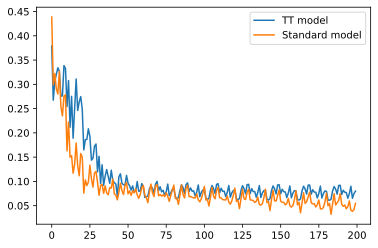

In [15]:
plt.plot(losses, label="TT model")
plt.plot(usual_losses, label="Standard model")
plt.legend()
plt.show()